In [1]:
#!pip install transformers

In [2]:
#!pip install torch

In [3]:
#!pip install scikit-learn


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
#load in all the data sets

# kaggle_train = pd.read_csv('datasets/kaggle-data/train_essays.csv') 
# kaggle_prompts = pd.read_csv('datasets/kaggle-data/train_prompts.csv')

#The DAIGT_concatenated dataset can be downloaded from: https://www.kaggle.com/datasets/dsluciano/daigt-one-place-all-data?select=concatenated.csv
daigt_external_data = pd.read_csv('DAIGT_concatenated.csv')

# test_data_fixed = pd.read_csv('datasets/external-data/test_preprocessed_fixed.csv')
# # train_essays_v1 = pd.read_csv('datasets/external-data/train_essays_RDizzl3_seven_v1.csv')
# # train_data_fixed = pd.read_csv('datasets/external-data/train_preprocessed_fixed.csv')
# # train_v2_raw = pd.read_csv('datasets/external-data/train_v2_drcat_02_raw.csv')


In [5]:
# Count 1s and 0s in 'generated' column for daigt_external_data
daigt_external_counts = daigt_external_data['generated'].value_counts()

print("\nDAIGT External Data - 'generated' column counts:")
print(daigt_external_counts)


DAIGT External Data - 'generated' column counts:
generated
0    29907
1    24784
Name: count, dtype: int64


Based on the above output (Kaggle Train - 'generated' column counts:
0    1375
1       3
DAIGT External Data - 'generated' column counts:
0    29907
1    24784), 
we disregard the Kaggle training set and work with the compiled externel DAIGT data set instead.

In [7]:
daigt_external_data.head()

,id,prompt_id,text,generated,model,kaggle_repo
0,d429f032,0,Advantages of Limiting Car Usage \n\nLimiting ...,1,gpt-3.5-turbo,1
1,1ce279be,0,Advantages of Limiting Car Usage\n\nLimiting c...,1,gpt-3.5-turbo,1
2,c9595213,0,Limiting car usage has numerous advantages tha...,1,gpt-3.5-turbo,1
3,f2266d87,0,The passages provided discuss the advantages o...,1,gpt-3.5-turbo,1
4,eeace4bd,0,Title: The Advantages of Limiting Car Usage\n\...,1,gpt-3.5-turbo,1


In [40]:
found = 0
for idx, label in enumerate(daigt_external_data['generated']):
    if label == 0:
        print(idx, label)
        found += 1
    if found == 10:
        break

19942 0
19943 0
19944 0
19945 0
19946 0
19947 0
19948 0
19949 0
19950 0
19951 0


In [44]:
#example human text
print(daigt_external_data['text'][19942])

Phones

Modern humans today are always on their phone. They are always on their phone more than 5 hours a day no stop .All they do is text back and forward and just have group Chats on social media. They even do it while driving. They are some really bad consequences when stuff happens when it comes to a phone. Some certain areas in the United States ban phones from class rooms just because of it.

When people have phones, they know about certain apps that they have .Apps like Facebook Twitter Instagram and Snapchat. So like if a friend moves away and you want to be in contact you can still be in contact by posting videos or text messages. People always have different ways how to communicate with a phone. Phones have changed due to our generation.

Driving is one of the way how to get around. People always be on their phones while doing it. Which can cause serious Problems. That's why there's a thing that's called no texting while driving. That's a really important thing to remember. S

In [39]:
#example AI text
print(daigt_external_data['text'][1])

Advantages of Limiting Car Usage

Limiting car usage can have numerous advantages for individuals and communities. It can help reduce greenhouse gas emissions, improve air quality, promote healthier lifestyles, reduce traffic congestion, and create more vibrant and walkable neighborhoods. These benefits have been observed in various places around the world where car usage has been limited.

One example is Vauban, a car-free community in Germany, where 70 percent of families do not own cars. Residents of Vauban have reported feeling happier and less stressed since giving up their cars (Rosenthal, paragraph 3). This is because cars can be a source of tension and anxiety. In contrast, walking and biking in car-free neighborhoods can provide a sense of freedom and connection to the community.

Another advantage of limiting car usage is the reduction of greenhouse gas emissions. Cars are responsible for a significant portion of these emissions, particularly in car-intensive areas. For examp

In [27]:
text_lengths = []
for text in daigt_external_data['text']:
    words = text.split()
    text_lengths.append(len(words))


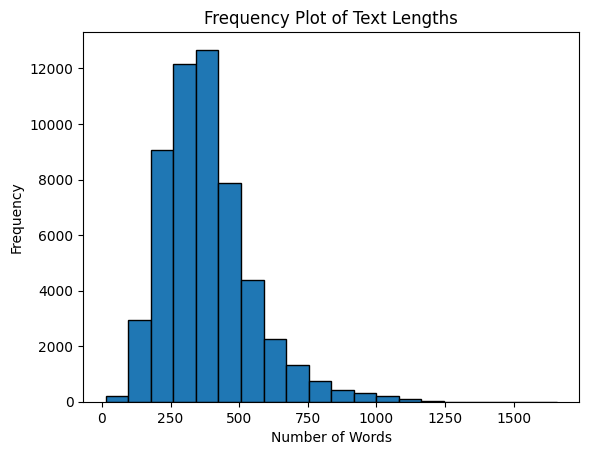

In [38]:
plt.hist(text_lengths, bins=20, edgecolor='black')  # Adjust bins as needed
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Frequency Plot of Text Lengths')
plt.savefig('text_length_distribution.png', format='png', dpi=300)  # dpi=300 for high quality
plt.show()



# Output next word probability vector using AutoModel

Sources: [https://huggingface.co/transformers/v3.0.2/model_doc/auto.html](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html)
[https://stackoverflow.com/questions/76397904/generate-the-probabilities-of-all-the-next-possible-word-for-a-given-text](https://stackoverflow.com/questions/76397904/generate-the-probabilities-of-all-the-next-possible-word-for-a-given-text)
[https://www.kaggle.com/code/funtowiczmo/hugging-face-transformers-get-started](https://www.kaggle.com/code/funtowiczmo/hugging-face-transformers-get-started)

In [6]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Ensure reproducibility
np.random.seed(42)
torch.manual_seed(42)


/spack/conda/miniforge3/24.3.0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Split into training and testing sets (80% train, 20% test)
train_data, test_data = train_test_split(
    daigt_external_data, test_size=0.2, random_state=42, stratify=daigt_external_data['generated']
)

print(f"Training samples: {len(train_data)}")
print(f"Testing samples: {len(test_data)}")

Training samples: 43752
Testing samples: 10939


In [8]:
#The size of the data above leads to long compute times in processing the data (into vectors of probabilites) and to train the neural network). Let's therefore use a smaller dataset to begin with
small_data = daigt_external_data.sample(n=2400, random_state=42)
small_train_data, small_test_data = train_test_split(
    small_data, test_size=400, random_state=42, stratify=small_data['generated']
)

print(f"Training samples: {len(small_train_data)}")
print(f"Testing samples: {len(small_test_data)}")

Training samples: 2000
Testing samples: 400


In [8]:
import torch
from transformers import AutoModelForCausalLM , AutoTokenizer
#Define language model class
class LMHeadModel:

    def __init__(self, model_name):
        # Initialize the model and the tokenizer.
        self.model = AutoModelForCausalLM.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    def get_predictions(self, sentence):
        # Encode the sentence using the tokenizer and return the model predictions.
        inputs = self.tokenizer.encode(sentence, return_tensors="pt")
        with torch.no_grad():
            outputs = self.model(inputs)
            predictions = outputs[0]
        return predictions
    
    def get_next_word_probabilities(self, sentence, top_k=500):

        # Get the model predictions for the sentence.
        predictions = self.get_predictions(sentence)
        
        # Get the next token candidates.
        next_token_candidates_tensor = predictions[0, -1, :]

        # Get the top k next token candidates.
        topk_candidates_indexes = torch.topk(
            next_token_candidates_tensor, top_k).indices.tolist()

        # Get the token probabilities for all candidates.
        all_candidates_probabilities = torch.nn.functional.softmax(
            next_token_candidates_tensor, dim=-1)
        
        # Filter the token probabilities for the top k candidates.
        topk_candidates_probabilities = \
            all_candidates_probabilities[topk_candidates_indexes].tolist()

        # Decode the top k candidates back to words.
        topk_candidates_tokens = \
            [self.tokenizer.decode([idx]).strip() for idx in topk_candidates_indexes]

        # Return the top k candidates and their probabilities.
        return list(zip(topk_candidates_tokens, topk_candidates_probabilities))

In [15]:
#pip install transformers huggingface-hub
huggingface-cli login


SyntaxError: invalid syntax (3697112923.py, line 2)

In [9]:
# Initialize the language model
#list of models to try:     
#model_name = 'gpt2'
#model_name = 'meta-llama/Llama-3.2-1B', 
model_name = 'mistralai/Mistral-7B-v0.1' 
#model_name = 'EleutherAI/gpt-neo-125M'
#model_name = 'distilgpt2'
#model_name = 'tiiuae/falcon-7b'
#model_name = 'nvidia/Llama-3.1-Nemotron-70B-Instruct-HF'
lm_model = LMHeadModel(model_name)

Loading checkpoint shards:   0%|          | 0/2 [00:49<?, ?it/s]


KeyboardInterrupt: 

In [29]:
def process_text(text, lm_model, num_splits=50):
    """
    Process a single text to generate a vector of true next word probabilities.
    """
    # Split the text into words
    words = text.split()
    probabilities = []

    # Ensure there are enough words to sample
    if len(words) < 2:
        return [0.0] * num_splits  # Return zeros if not enough words

    # Generate 50 split points
    for _ in range(num_splits):
        # Randomly select a word index (excluding the last word)
        split_idx = np.random.randint(1, len(words))
        context_words = words[:split_idx]
        true_next_word = words[split_idx]

        # Reconstruct the context sentence
        context_sentence = ' '.join(context_words)

        # Get the next word probabilities
        try:
            next_word_probs = lm_model.get_next_word_probabilities(context_sentence, top_k=500)
        except Exception as e:
            print(f"Error processing context: {e}")
            probabilities.append(0.0)
            continue

        # Find the probability of the true next word
        true_word_prob = 0.0
        for word, prob in next_word_probs:
            if word == true_next_word:
                true_word_prob = prob
                break  # Stop searching once found

        probabilities.append(true_word_prob)

    return probabilities


In [30]:
# Prepare lists to store the results
X_train = []
y_train = []

# Process training data
print("Processing training data...")
for idx, row in tqdm(train_data.iterrows(), total=len(train_data)):
    text = row['text']
    label = row['generated']
    probs_vector = process_text(text, lm_model, num_splits=10)
    X_train.append(probs_vector)
    y_train.append(label)

# Convert lists to tensors or arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
# Save the numpy arrays to .npy files
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)

# Similarly process the test data
X_test = []
y_test = []

print("Processing testing data...")
for idx, row in tqdm(test_data.iterrows(), total=len(test_data)):
    text = row['text']
    label = row['generated']
    probs_vector = process_text(text, lm_model, num_splits=10)
    X_test.append(probs_vector)
    y_test.append(label)

X_test = np.array(X_test)
y_test = np.array(y_test)
# Save the numpy arrays to .npy files
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

Processing training data...


  7%|▋         | 131/2000 [03:19<43:49,  1.41s/it] Token indices sequence length is longer than the specified maximum sequence length for this model (1076 > 1024). Running this sequence through the model will result in indexing errors


Error processing context: index out of range in self


 17%|█▋        | 347/2000 [08:49<50:00,  1.82s/it]  

Error processing context: index out of range in self


 28%|██▊       | 551/2000 [13:46<30:32,  1.26s/it]

Error processing context: index out of range in self
Error processing context: index out of range in self


 28%|██▊       | 559/2000 [14:01<47:16,  1.97s/it]

Error processing context: index out of range in self


 32%|███▏      | 643/2000 [16:11<42:23,  1.87s/it]

Error processing context: index out of range in self


 36%|███▌      | 714/2000 [17:56<36:23,  1.70s/it]

Error processing context: index out of range in self


 39%|███▊      | 771/2000 [19:22<32:33,  1.59s/it]

Error processing context: index out of range in self


 45%|████▌     | 902/2000 [22:43<26:53,  1.47s/it]

Error processing context: index out of range in self
Error processing context: index out of range in self
Error processing context: index out of range in self


 46%|████▋     | 926/2000 [23:21<30:21,  1.70s/it]

Error processing context: index out of range in self
Error processing context: index out of range in self
Error processing context: index out of range in self


 46%|████▋     | 927/2000 [23:22<29:22,  1.64s/it]

Error processing context: index out of range in self


 64%|██████▍   | 1284/2000 [32:17<17:58,  1.51s/it]

Error processing context: index out of range in self
Error processing context: index out of range in self


 64%|██████▍   | 1285/2000 [32:18<17:48,  1.49s/it]

Error processing context: index out of range in self


 69%|██████▉   | 1389/2000 [34:50<13:38,  1.34s/it]

Error processing context: index out of range in self
Error processing context: index out of range in self


 72%|███████▏  | 1442/2000 [36:15<16:17,  1.75s/it]

Error processing context: index out of range in self
Error processing context: index out of range in self
Error processing context: index out of range in self


 72%|███████▏  | 1443/2000 [36:16<14:47,  1.59s/it]

Error processing context: index out of range in self


 77%|███████▋  | 1541/2000 [38:42<12:39,  1.65s/it]

Error processing context: index out of range in self


 83%|████████▎ | 1654/2000 [41:30<08:00,  1.39s/it]

Error processing context: index out of range in self


 96%|█████████▌| 1910/2000 [47:56<02:36,  1.74s/it]

Error processing context: index out of range in self
Error processing context: index out of range in self


 98%|█████████▊| 1963/2000 [49:19<00:48,  1.30s/it]

Error processing context: index out of range in self


100%|██████████| 2000/2000 [50:18<00:00,  1.51s/it]


Processing testing data...


 30%|██▉       | 118/400 [14:43<40:17,  8.57s/it]

Error processing context: index out of range in self


 36%|███▌      | 143/400 [17:45<26:08,  6.10s/it]

Error processing context: index out of range in self
Error processing context: index out of range in self


 62%|██████▏   | 246/400 [31:11<18:37,  7.26s/it]

Error processing context: index out of range in self
Error processing context: index out of range in self
Error processing context: index out of range in self
Error processing context: index out of range in self
Error processing context: index out of range in self
Error processing context: index out of range in self
Error processing context: index out of range in self
Error processing context: index out of range in self
Error processing context: index out of range in self
Error processing context: index out of range in self
Error processing context: index out of range in self
Error processing context: index out of range in self


 62%|██████▏   | 247/400 [31:21<20:39,  8.10s/it]

Error processing context: index out of range in self
Error processing context: index out of range in self


 66%|██████▋   | 266/400 [33:51<16:44,  7.50s/it]

Error processing context: index out of range in self
Error processing context: index out of range in self
Error processing context: index out of range in self
Error processing context: index out of range in self
Error processing context: index out of range in self


 72%|███████▏  | 286/400 [36:18<13:08,  6.91s/it]

Error processing context: index out of range in self
Error processing context: index out of range in self
Error processing context: index out of range in self
Error processing context: index out of range in self
Error processing context: index out of range in self
Error processing context: index out of range in self
Error processing context: index out of range in self
Error processing context: index out of range in self
Error processing context: index out of range in self
Error processing context: index out of range in self
Error processing context: index out of range in self
Error processing context: index out of range in self


 72%|███████▏  | 287/400 [36:28<14:54,  7.92s/it]

Error processing context: index out of range in self
Error processing context: index out of range in self
Error processing context: index out of range in self


100%|██████████| 400/400 [50:13<00:00,  7.53s/it]


In [31]:
#Prepare to feed into neural net
#Replace zeros with a small value to avoid issues in log transformation
epsilon = 1e-10
X_train = np.where(X_train == 0, epsilon, X_train)
X_test = np.where(X_test == 0, epsilon, X_test)

# Apply log transformation
X_train = np.log(X_train)
X_test = np.log(X_test)

In [27]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create datasets and data loaders
batch_size = 32

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [29]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 2)  # Binary classification

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [30]:
input_size = X_train.shape[1]
model = FeedForwardNN(input_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [33]:
#Train the network
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss over the epoch
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/10], Loss: 0.5706
Epoch [2/10], Loss: 0.5695
Epoch [3/10], Loss: 0.5711
Epoch [4/10], Loss: 0.5705
Epoch [5/10], Loss: 0.5690
Epoch [6/10], Loss: 0.5696
Epoch [7/10], Loss: 0.5671
Epoch [8/10], Loss: 0.5675
Epoch [9/10], Loss: 0.5682
Epoch [10/10], Loss: 0.5664


In [39]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (2000, 10)
X_test shape: (400, 50)


In [40]:
# Randomly select 10 indices from 0 to 49 without replacement
selected_indices = np.random.choice(50, size=10, replace=False)

# Select the probabilities at the chosen indices
X_test_adjusted = X_test[:, selected_indices]

# Proceed with evaluation using X_test_adjusted
X_test_tensor = torch.tensor(X_test_adjusted, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create a new DataLoader for the adjusted test data
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
#Evaluate model
from sklearn.metrics import accuracy_score, classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())
        
# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")

# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, digits=4))

Using only gpt-2 and 10 split points per text, we get the following results: Test Accuracy: 0.6225
Classification Report:
              precision    recall  f1-score   support

           0     0.7027    0.5752    0.6326       226
           1     0.5535    0.6839    0.6118       174

    accuracy                         0.6225       400
   macro avg     0.6281    0.6296    0.6222       400
weighted avg     0.6378    0.6225    0.6236       400

# Classify based on last hidden state

In [9]:
#list of models to try:     
#Tried:
#model_name = 'gpt2'
#model_name = 'meta-llama/Llama-3.2-1B'
#model_name = 'mistralai/Mistral-7B-v0.1' - too slow
model_name = 'google/gemma-2-2b'
#Yet to try:
#model_name = 'EleutherAI/gpt-neo-125M'
#model_name = 'distilgpt2'
#model_name = 'tiiuae/falcon-7b'
#model_name = 'nvidia/Llama-3.1-Nemotron-70B-Instruct-HF'
#model_name = 'meta-llama/Llama-3.1-8B-Instruct'


tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, return_dict_in_generate=True, output_hidden_states=True)

Loading checkpoint shards: 100%|██████████| 3/3 [00:31<00:00, 10.39s/it]


In [10]:
# Define function to get last token embedding
def get_last_token_embedding(text, tokenizer, model, max_length=512):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_length)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    hidden_states = outputs.hidden_states
    last_hidden_state = hidden_states[-1]  # Last layer's hidden state
    last_token_embedding = last_hidden_state[0, -1, :]  # [batch_idx, token_idx, hidden_size]
    return last_token_embedding.numpy()

In [11]:
# Process training data
X_train = []
y_train = []

print("Processing training data...")
for idx, row in tqdm(small_train_data.iterrows(), total=len(small_train_data)):
    text = row['text']
    label = row['generated']
    try:
        embedding = get_last_token_embedding(text, tokenizer, model)
        X_train.append(embedding)
        y_train.append(label)
    except Exception as e:
        print(f"Error processing text at index {idx}: {e}")


# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
# Save the numpy arrays to .npy files
np.save('X_train_gemma-2-2b_embed.npy', X_train)
np.save('y_train_gemma-2-2b_embed.npy', y_train)

# Process testing data
X_test = []
y_test = []

print("Processing testing data...")
for idx, row in tqdm(small_test_data.iterrows(), total=len(small_test_data)):
    text = row['text']
    label = row['generated']
    try:
        embedding = get_last_token_embedding(text, tokenizer, model)
        X_test.append(embedding)
        y_test.append(label)
    except Exception as e:
        print(f"Error processing text at index {idx}: {e}")


X_test = np.array(X_test)
y_test = np.array(y_test)
# Save the numpy arrays to .npy files
np.save('X_test_gemma-2-2b_embed.npy', X_test)
np.save('y_test_gemma-2-2b_embed.npy', y_test)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

Processing training data...


100%|██████████| 2000/2000 [1:16:53<00:00,  2.31s/it]


Processing testing data...


100%|██████████| 400/400 [12:35<00:00,  1.89s/it]

X_train shape: (2000, 2304)
X_test shape: (400, 2304)


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [18]:
#%pip install matplotlib

In [19]:
# Train Random Forest classifier

import matplotlib.pyplot as plt
X_train = np.load('X_train_GPT2_embed.npy')
y_train = np.load('y_train_GPT2_embed.npy')
X_test = np.load('X_test_GPT2_embed.npy')
y_test = np.load('y_test_GPT2_embed.npy')
clf_gpt2 = RandomForestClassifier(n_estimators=100, random_state=42)
clf_gpt2.fit(X_train, y_train)

# Evaluate the model
y_pred = clf_gpt2.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

Test Accuracy: 0.9500
Classification Report:
              precision    recall  f1-score   support

           0     0.9292    0.9867    0.9571       226
           1     0.9812    0.9023    0.9401       174

    accuracy                         0.9500       400
   macro avg     0.9552    0.9445    0.9486       400
weighted avg     0.9518    0.9500    0.9497       400



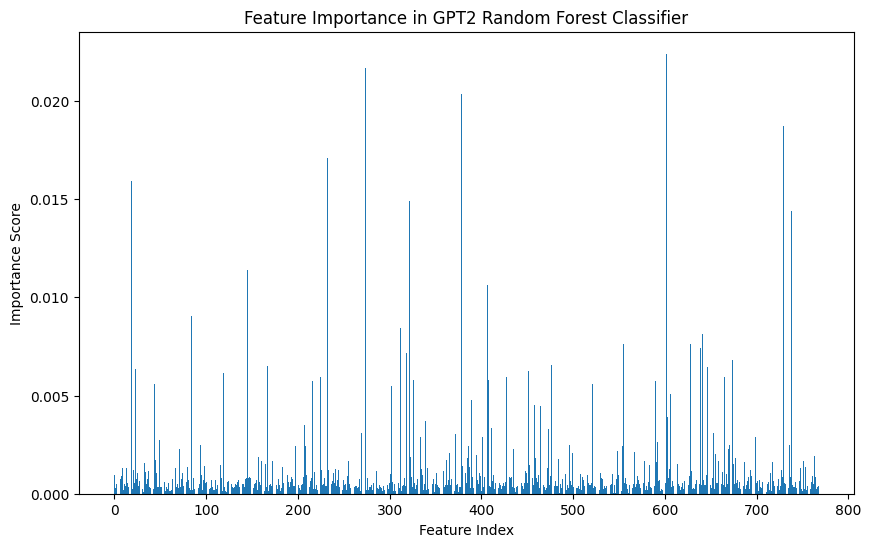

In [20]:
# Feature importances
feature_importances = clf_gpt2.feature_importances_

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.title("Feature Importance in GPT2 Random Forest Classifier")
plt.show()


In [24]:
# Assuming you have already trained the classifier and obtained feature_importances
important_features = [index for index, importance in enumerate(feature_importances) if importance > 0.015]

# Print or return the list of important feature indices
print("Features with importance score above 0.015:", important_features)

Features with importance score above 0.015: [6, 19, 232, 274, 378, 526, 602, 635, 683, 696, 729]


In [21]:
#try random forest with Llamma 3.2-1B

import matplotlib.pyplot as plt
X_train = np.load('X_train_Llama-3.2-1B_embed.npy')
y_train = np.load('y_train_Llama-3.2-1B_embed.npy')
X_test = np.load('X_test_Llama-3.2-1B_embed.npy')
y_test = np.load('y_test_Llama-3.2-1B_embed.npy')
clf_llama_3_2_1B = RandomForestClassifier(n_estimators=100, random_state=42)
clf_llama_3_2_1B.fit(X_train, y_train)

# Evaluate the model
y_pred = clf_llama_3_2_1B.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

Test Accuracy: 0.9725
Classification Report:
              precision    recall  f1-score   support

           0     0.9654    0.9867    0.9759       226
           1     0.9822    0.9540    0.9679       174

    accuracy                         0.9725       400
   macro avg     0.9738    0.9704    0.9719       400
weighted avg     0.9727    0.9725    0.9725       400



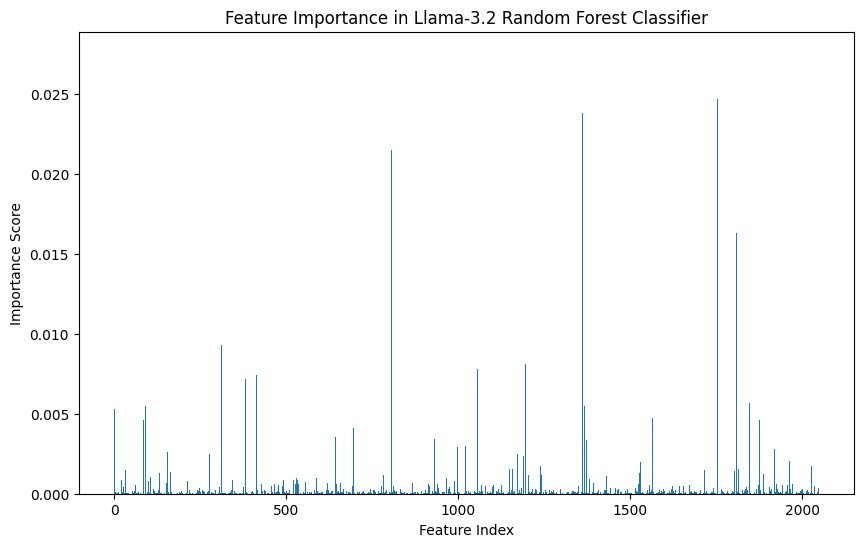

In [22]:
# Feature importances
feature_importances = clf_llama_3_2_1B.feature_importances_

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.title("Feature Importance in Llama-3.2 Random Forest Classifier")
plt.show()


In [25]:
import matplotlib.pyplot as plt
X_train = np.load('X_train_gemma-2-2b_embed.npy')
y_train = np.load('y_train_gemma-2-2b_embed.npy')
X_test = np.load('X_test_gemma-2-2b_embed.npy')
y_test = np.load('y_test_gemma-2-2b_embed.npy')
clf_gemma = RandomForestClassifier(n_estimators=100, random_state=42)
clf_gemma.fit(X_train, y_train)

# Evaluate the model
y_pred = clf_gemma.predict(X_test)

print(X_train.shape)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

(2000, 2304)
Test Accuracy: 0.9750
Classification Report:
              precision    recall  f1-score   support

           0     0.9655    0.9912    0.9782       226
           1     0.9881    0.9540    0.9708       174

    accuracy                         0.9750       400
   macro avg     0.9768    0.9726    0.9745       400
weighted avg     0.9753    0.9750    0.9749       400



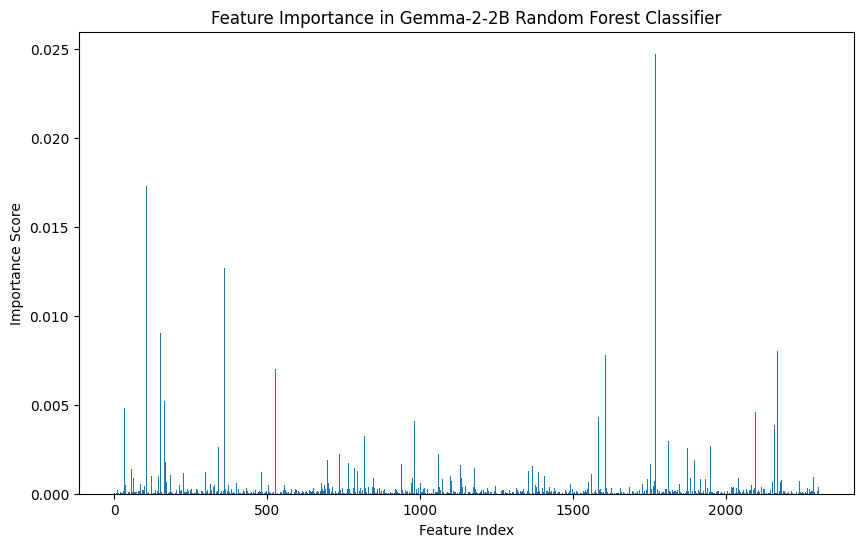

In [26]:
# Feature importances
feature_importances = clf_gemma.feature_importances_

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.title("Feature Importance in Gemma-2-2B Random Forest Classifier")
plt.show()

In [51]:
ai_text = 'Sleeping well and exercising regularly are foundational pillars for both physical and mental health. Quality sleep allows the body to recover, repair, and recharge. During sleep, essential processes such as muscle repair, immune function strengthening, and memory consolidation occur, all of which are vital for maintaining good health. Poor sleep, on the other hand, can lead to weakened immunity, cognitive issues, and increased stress levels. People who get adequate sleep tend to have better concentration, more stable emotions, and a lower risk of developing chronic health conditions. Exercise complements sleep by boosting physical health, mental clarity, and energy levels. Regular physical activity strengthens the cardiovascular system, enhances lung capacity, and increases muscle tone. Exercise also releases endorphins, the body’s natural mood enhancers, which help reduce stress and promote happiness. People who exercise regularly often experience deeper and more restorative sleep, as physical exertion helps regulate the sleep-wake cycle, making it easier to fall asleep and stay asleep. Together, sleep and exercise create a positive feedback loop that amplifies overall wellness. Good sleep boosts energy, which leads to better workouts; effective exercise further promotes quality sleep, creating a cycle of health benefits. This synergy between sleep and exercise not only improves immediate well-being but also supports long-term health by reducing the risks of heart disease, diabetes, and mental health disorders. Therefore, prioritizing both good sleep and regular exercise is essential for living a balanced, healthy, and fulfilling life.'
gemma_embedding = np.array([get_last_token_embedding(ai_text, tokenizer, model)])
y_pred = clf_gemma.predict(gemma_embedding)
print(y_pred)

[1]


In [53]:
human_text = 'The use of animals for research and testing has been a part of human practice for thousands of years, giving our species a variety of medical and commercial products. However, it bears a heavy ethical burden: do we have the right to treat other species however we want? Is the suffering endured by the millions of animals across the globe every year compensated by the benefits we extract? The issue of animal testing is complex and intricate, with both sides presenting strong arguments. To understand both positions well, and therefore to push ourselves closer to some sort of balance between the good and the bad, let us examine some arguments from either side. One of the primary arguments on the pro-testing side is that, historically, animal testing has led to some of the most powerful breakthroughs in all of medicine. From the vivisections of ancient Greece to the discovery of penicillin in the 20th century, the study of and experimentation with animal anatomy has formed the basis of biomedical research. In the past century alone, the use of animals in experiments has led to the ability to conduct successful blood transfusions, to combat asthma, to create vaccines for Meningitis, to transplant kidneys, and to the suppression of Tuberculosis. Within this short list, hundreds of millions of lives have either been saved or been dramatically improved. The full extent of the benefits is truly incalculable. [1,2] The opposition to this viewpoint, acknowledging the benefits mentioned above, still think that this form of testing is morally indefensible. Each year, ignoring all the experiments and tests done outside the U.S., approximately 100 million mice and rats are used in experiments, plus about 1 million animals from other species (excluding mice, rats, birds, reptiles, agricultural animals). In the United Kingdom, out of about 2 million experimental procedures completed in 2015, 150 thousand of them were classified as “severe”, which denotes experiments that cause long-term disease, the need for assistance for basic processes like eating and drinking, and the provocation of self-mutilation due to high levels of stress.[3] Some animals are forced to inhale toxic fumes, have holes drilled into their skulls, have their skin burned off, or their spinal cords crushed. Therefore, one needs to consider not only the number of deaths caused by medical training, experimentation and testing (about 100,000,000 per year in the U.S.) [3], but also the unimaginable levels of suffering and misery these conscious beings experience before their deaths.'
gemma_embedding = np.array([get_last_token_embedding(human_text, tokenizer, model)])
y_pred = clf_gemma.predict(gemma_embedding)
print(y_pred)


[0]


In [55]:
s_text = 'Body-functionality based interventions improve negative body image by targeting self-objectification. They encourage women to shift their focus from the outward appearance of their body to its expressing appreciation for the functions it performs. Body-functionality based interventions have been proven to increase self-compassion, reduce body image dissatisfaction and improve overall well-being in adult women.'
gemma_embedding = np.array([get_last_token_embedding(s_text, tokenizer, model)])
y_pred = clf_gemma.predict(gemma_embedding)
print(y_pred)

[1]


In [43]:
X_train = np.load('X_train_Llama-3.2-1B_embed.npy')
y_train = np.load('y_train_Llama-3.2-1B_embed.npy')
X_test = np.load('X_test_Llama-3.2-1B_embed.npy')
y_test = np.load('y_test_Llama-3.2-1B_embed.npy')
print(y_train)
print(f"y_train data type: {y_train.dtype}, shape: {y_train.shape}")
print(f"y_test data type: {y_test.dtype}, shape: {y_test.shape}")

[0 1 0 ... 1 0 1]
y_train data type: int64, shape: (2000,)
y_test data type: int64, shape: (400,)


In [50]:
embedding = np.array([get_last_token_embedding(train_data['text'][0], tokenizer, model)])
for idx, row in tqdm(small_test_data.iterrows(), total=len(small_test_data)):
        if idx == 5:
            break
        label = row['generated']
        #print(idx, label)

100%|██████████| 400/400 [00:00<00:00, 29505.66it/s]


In [46]:
for idx, row in tqdm(small_test_data.iterrows(), total=len(small_test_data)):
        if idx == 5:
            break
        label = row['generated']
        #print(idx, label)
print(model)

100%|██████████| 400/400 [00:00<00:00, 31606.22it/s]

Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2Attention(
          (q_proj): Linear(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2304, bias=False)
          (rotary_emb): Gemma2RotaryEmbedding()
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear(in_features=9216, out_features=2304, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (pre_feedforward_layernorm): Gemma2RMSNorm((2304,), eps